# Naive Momentum Trading Strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('monthlyReturnSpxConstituents.tsv', sep = "\t")

In [3]:
data.head()

,ticker,date,adjClose
0,AAPL,2015-12-31,98.115420
1,AAPL,2016-01-29,90.732995
2,AAPL,2016-02-29,90.612270
3,AAPL,2016-03-31,102.139118
4,AAPL,2016-04-29,87.847701


In [4]:
symbol_list = []
df_list = []
for symbol, df in data.groupby(by = ['ticker']):
    symbol_list.append(symbol)
    df_list.append(df)

In [17]:
def AddLags(df):
    df['1-month-return'] = df['adjClose'].pct_change(1)
    df['3-month-return'] = df['adjClose'].pct_change(3)
    df['6-month-return'] = df['adjClose'].pct_change(6)
    df['12-month-return'] = df['adjClose'].pct_change(12)
    df['y'] = df['1-month-return'].shift(-1)
    return df.dropna()

In [19]:
df_list = [AddLags(df) for df in df_list]

In [67]:
def Select_Data(df_list, start, next_period):
    df_list_new = []
    test_list = []
    for df in df_list:
        df_new = df.set_index(['date']).loc[start:next_period][['1-month-return', '3-month-return', '6-month-return', '12-month-return', 'y']]
        df_list_new.append(df_new.iloc[:-1, :])
        test_list.append(df_new.iloc[-1:, :])
    result = pd.concat(df_list_new, axis = 0).reset_index()
    x_train = np.array(result.drop(['date', 'y'], axis = 1))
    y_train = np.array(result['y'])
    test_result = pd.concat(test_list, axis = 0).reset_index()
    x_test = np.array(test_result.drop(['date','y'], axis = 1))
    y_test = np.array(test_result['y'])
    return x_train, y_train, x_test, y_test

In [30]:
date_list = list(df_list[0]['date'])

In [68]:
training_stage = []
for i in range(len(date_list) - 25):
    training_stage.append(('stage ' + str(i+1), date_list[i], date_list[i + 25]))

In [77]:
def Compute_Return(y_pred, y_test, Portfolio_Num, weighted = 'Equal'):
    table = pd.DataFrame({'y_pred':y_pred, 'Rank': range(len(y_pred)), 'y_true':y_test})
    Upper_table = table.nlargest(Portfolio_Num, 'y_pred')
    Lower_table = table.nsmallest(Portfolio_Num, 'y_pred')
    upper_true = np.array(Upper_table['y_true'])
    lower_true = np.array(Lower_table['y_true']) * (-1)
    if weighted == 'Equal':
        weight = np.ones(Portfolio_Num)/Portfolio_Num
    if weighted == 'Rank':
        weight = range(1, Portfolio_Num + 1)/np.array(range(1, Portfolio_Num)).sum()
    if weighted == 'Sqrt':
        weight = np.sqrt(range(1, Portfolio_Num + 1))/ np.sqrt(range(1, Portfolio_Num + 1)).sum()
    ret_upper = upper_true.T @ weight
    ret_lower = lower_true.T @ weight
    return (ret_upper + ret_lower)/2

In [87]:
training_stage

[('stage 1', '2016-12-30', '2019-01-31'),
 ('stage 2', '2017-01-31', '2019-02-28'),
 ('stage 3', '2017-02-28', '2019-03-29'),
 ('stage 4', '2017-03-31', '2019-04-30'),
 ('stage 5', '2017-04-28', '2019-05-31'),
 ('stage 6', '2017-05-31', '2019-06-28'),
 ('stage 7', '2017-06-30', '2019-07-31'),
 ('stage 8', '2017-07-31', '2019-08-30'),
 ('stage 9', '2017-08-31', '2019-09-30'),
 ('stage 10', '2017-09-29', '2019-10-31'),
 ('stage 11', '2017-10-31', '2019-11-29'),
 ('stage 12', '2017-11-30', '2019-12-31'),
 ('stage 13', '2017-12-29', '2020-01-31')]

## Assumption

In order to apply this strategy, we need to have those time series stationary.
EDA: get stock with significant trend
step 1: transform price data to return data -- stationary
step 2: feature importance to determine feature and to see the intuition
step 3: feature engineering (1) cumulative (2) macro variables (3) AR
step 4: portfolio construction
step 5: consider turnover & transaction cost
step 6: risk management vol management & stop loss
step 7: rebalancing

### OLS Model

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
def OLS_train(x_train, y_train, x_test):
    reg = LinearRegression().fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    return y_pred

In [93]:
def OLS_Stage_Result(df_list, training_stage, Portfolio_Num, weight_method):
    result = []
    stage = []
    for i in range(len(training_stage)):
        stage.append(training_stage[i][0])
        x_train, y_train, x_test, y_test = Select_Data(df_list, training_stage[i][1], training_stage[i][2])
        y_pred = OLS_train(x_train, y_train, x_test)
        result.append(Compute_Return(y_pred, y_test, Portfolio_Num, weight_method))
    result_df = pd.DataFrame({'Stage':stage, 'Return':result}) 
    result_df['NetValue'] = (result_df['Return'] + 1).cumprod()
    return result_df

In [103]:
def print_result(df_list, training_stage, model):
    method_list = ['Rank', 'Equal', 'Sqrt']
    Num = [20, 40, 60, 80, 100]
    result = []
    for med in method_list:
        for num in Num:
            result.append(model(df_list, training_stage, num, med))
    
    fig, axs = plt.subplots(3, 2, figsize = (20, 8))
    axs[0, 0].plot(range(13), np.array(result[0]['NetValue']), label = 'Rank')
    axs[0, 0].plot(range(13), np.array(result[5]['NetValue']), label = 'Equal')
    axs[0, 0].plot(range(13), np.array(result[10]['NetValue']), label = 'Sqrt')
    axs[0, 0].legend()
    axs[0, 1].plot(range(13), np.array(result[1]['NetValue']), label = 'Rank')
    axs[0, 1].plot(range(13), np.array(result[6]['NetValue']), label = 'Equal')
    axs[0, 1].plot(range(13), np.array(result[11]['NetValue']), label = 'Sqrt')
    axs[0, 1].legend()
    axs[1, 0].plot(range(13), np.array(result[2]['NetValue']), label = 'Rank')
    axs[1, 0].plot(range(13), np.array(result[7]['NetValue']), label = 'Equal')
    axs[1, 0].plot(range(13), np.array(result[12]['NetValue']), label = 'Sqrt')
    axs[1, 0].legend()
    axs[1, 1].plot(range(13), np.array(result[3]['NetValue']), label = 'Rank')
    axs[1, 1].plot(range(13), np.array(result[8]['NetValue']), label = 'Equal')
    axs[1, 1].plot(range(13), np.array(result[13]['NetValue']), label = 'Sqrt')
    axs[1, 1].legend()
    axs[2, 0].plot(range(13), np.array(result[4]['NetValue']), label = 'Rank')
    axs[2, 0].plot(range(13), np.array(result[9]['NetValue']), label = 'Equal')
    axs[2, 0].plot(range(13), np.array(result[14]['NetValue']), label = 'Sqrt')
    axs[2, 0].legend()
    
    plt.show()

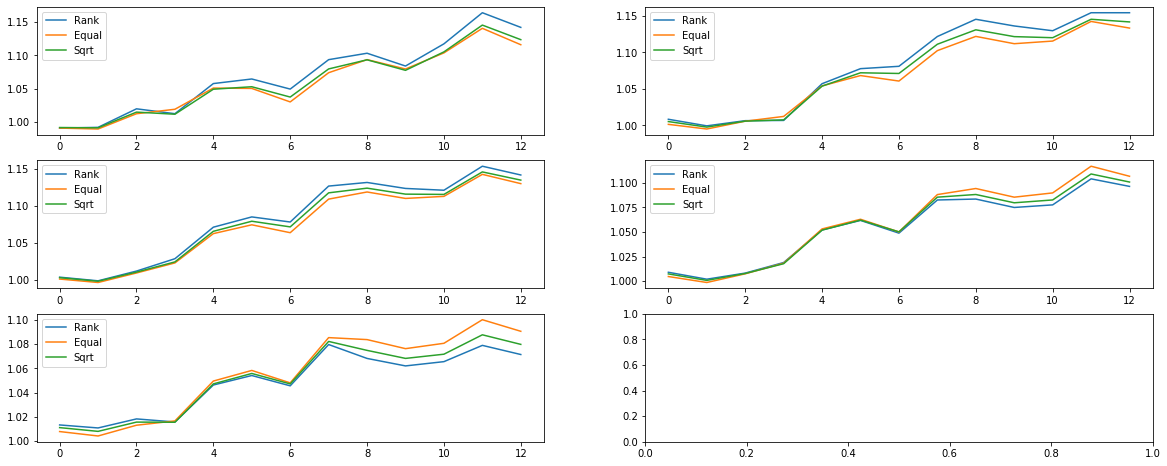

In [104]:
print_result(df_list, training_stage, OLS_Stage_Result)

### Random Forest

In [105]:
from sklearn.ensemble import RandomForestRegressor

In [112]:
def RF_train(x_train, y_train, x_test):
    reg = RandomForestRegressor(random_state=42, n_estimators = 100).fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    return y_pred

In [113]:
def RF_Stage_Result(df_list, training_stage, Portfolio_Num, weight_method):
    result = []
    stage = []
    for i in range(len(training_stage)):
        stage.append(training_stage[i][0])
        x_train, y_train, x_test, y_test = Select_Data(df_list, training_stage[i][1], training_stage[i][2])
        y_pred = RF_train(x_train, y_train, x_test)
        result.append(Compute_Return(y_pred, y_test, Portfolio_Num, weight_method))
    result_df = pd.DataFrame({'Stage':stage, 'Return':result}) 
    result_df['NetValue'] = (result_df['Return'] + 1).cumprod()
    return result_df

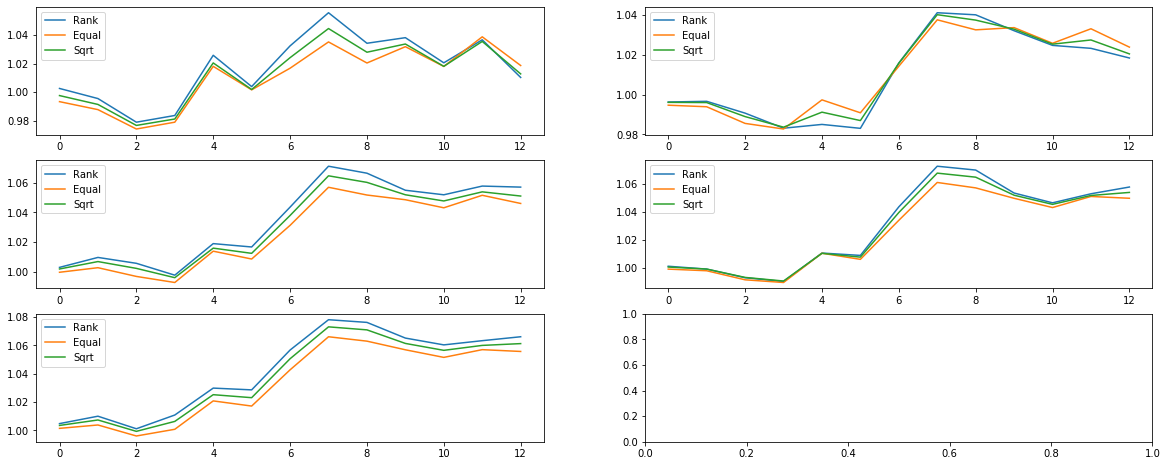

In [114]:
print_result(df_list, training_stage, RF_Stage_Result)